### 0. Preparation.

Импортируем необходимы библиотеки и модули.

In [1]:
import pandas as pd
import numpy as np

from sklearn import model_selection, metrics, pipeline, preprocessing
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor

import seaborn as sns

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

Загрузим датасет, познакомимся с данными.

In [3]:
df = pd.read_csv('Video_Games_Sales.csv')
print('Объем выборки:', df.shape)
df.head(5)

Объем выборки: (16719, 16)


,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


Описание данных:
- **Name** — Game's name
- **Platform** — Platform on which the game is implemented
- **YearofRelease** — Year of release
- **Genre** — Game's genre
- **Publisher** — Game's publisher
- **NA_Sales** — Sales in North America (in million)
- **EU_Sales** — Sales in europe (in million)
- **JP_Sales** — Sales in japan (in million)
- **Other_Sales** — Sales in other countries (in million)
- **Global_Sales** — Total sales (in million)
- **Critic_Score** — Aggregate score compiled by Metacritic staff
- **Criticcount** — The number of critics used in coming up with the Criticscore
- **User_Score** — Score by Metacritic's subscribers
- **Usercount** — Number of users who gave the userscore
- **Developer** — Party responsible for creating the game
- **Rating** — The ESRB ratings

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16719 entries, 0 to 16718
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16717 non-null  object 
 1   Platform         16719 non-null  object 
 2   Year_of_Release  16450 non-null  float64
 3   Genre            16717 non-null  object 
 4   Publisher        16665 non-null  object 
 5   NA_Sales         16719 non-null  float64
 6   EU_Sales         16719 non-null  float64
 7   JP_Sales         16719 non-null  float64
 8   Other_Sales      16719 non-null  float64
 9   Global_Sales     16719 non-null  float64
 10  Critic_Score     8137 non-null   float64
 11  Critic_Count     8137 non-null   float64
 12  User_Score       10015 non-null  object 
 13  User_Count       7590 non-null   float64
 14  Developer        10096 non-null  object 
 15  Rating           9950 non-null   object 
dtypes: float64(9), object(7)
memory usage: 2.0+ MB


Заметим, что значения признака User_Score были распознаны типом object, а не float64, как логично было бы предположить. Вернемся к этому в дальнейшем.

Посчитаем количество пропусков для каждого из признаков.

In [5]:
features_na = dict(df.isna().sum())
for feature, num_na in features_na.items():
    print('{: <18}  {}  {: >6}'.format(feature, '·', str(num_na)))

Name                ·       2
Platform            ·       0
Year_of_Release     ·     269
Genre               ·       2
Publisher           ·      54
NA_Sales            ·       0
EU_Sales            ·       0
JP_Sales            ·       0
Other_Sales         ·       0
Global_Sales        ·       0
Critic_Score        ·    8582
Critic_Count        ·    8582
User_Score          ·    6704
User_Count          ·    9129
Developer           ·    6623
Rating              ·    6769


Заметим, что при общем объеме выборки более 16 тысяч записей, последние шесть признаков имеют пропуски примерно в половине всех данных.

### 1. How many games have been released in each year? Which data is relevant?

In [6]:
# Посмотрим, какие года присутствуют в выборке.
years = sorted(set(df['Year_of_Release'].dropna().astype(int)))

print('В выборке присутствуют игры за {} - {} года, за исключением '.format(years[0], years[-1]), end='')
print(*(set(range(years[0], years[-1] + 1)) - set(years)), sep=', ', end=' годов.\n')

В выборке присутствуют игры за 1980 - 2020 года, за исключением 2018, 2019 годов.


In [7]:
# Посчитаем количество игр, выпущенных в каждом году.
games_per_year = []
for year in years:
    games_per_year.append((year, (df['Year_of_Release'] == year).sum()))
    
print('Количество игр, выпущенных в данный год:\n')
for k in range(10):
    idx = k
    while idx < len(years):
        print('{: <5} - {: > 5}'.format(*games_per_year[idx]), end='  |  ')
        idx += 10
    print()
    
print('\nКроме того в выборке {} игры без указания года выпуска.'.format(features_na['Year_of_Release']))

Количество игр, выпущенных в данный год:

1980  -     9  |  1990  -    16  |  2000  -   350  |  2010  -  1255  |  
1981  -    46  |  1991  -    41  |  2001  -   482  |  2011  -  1136  |  
1982  -    36  |  1992  -    43  |  2002  -   829  |  2012  -   653  |  
1983  -    17  |  1993  -    62  |  2003  -   775  |  2013  -   544  |  
1984  -    14  |  1994  -   121  |  2004  -   762  |  2014  -   581  |  
1985  -    14  |  1995  -   219  |  2005  -   939  |  2015  -   606  |  
1986  -    21  |  1996  -   263  |  2006  -  1006  |  2016  -   502  |  
1987  -    16  |  1997  -   289  |  2007  -  1197  |  2017  -     3  |  
1988  -    15  |  1998  -   379  |  2008  -  1427  |  2020  -     1  |  
1989  -    17  |  1999  -   338  |  2009  -  1426  |  

Кроме того в выборке 269 игры без указания года выпуска.


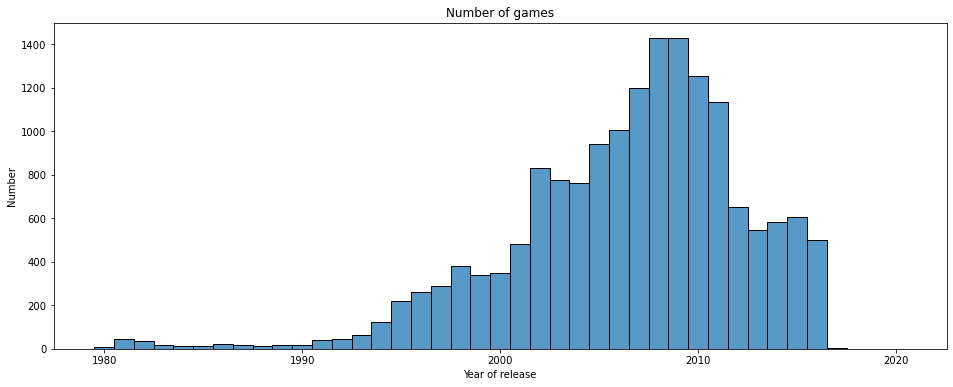

In [8]:
# Изобразим то же самое графически
fig, ax = plt.subplots(figsize=(16, 6))
sns.histplot(df['Year_of_Release'].dropna(), discrete=True, ax=ax)
plt.title('Number of games')
plt.xlabel('Year of release')
plt.ylabel('Number')
plt.show()

Из представленных данных выделим следующее:
1. Основной объем представленных в выборке игр был выпущен в период с 2000 по 2016 годы;
2. Кол-во игр в год для каждого года до 2000 невелико, но вкупе они образуют тяжелый левый хвост распредения.
3. Данная выборка актуальна на момент 2015–2016 годов. Игры более поздних лет представлены за 2017 (3 игры) и 2020 (1 игра) годы, но их суммарное количество ничтожно мало в масштабах выборки.

### 2. Analyze length of the platforms life by top-10 highest total platform's sales. Define relevant period.

In [9]:
# Посмотрим, игры для каких платформ представлены в выборке.
platforms = sorted(set(df['Platform']))

print('Представлены игры для следующих платформ (в алфавитном порядке):\n')
print(*platforms, sep=', ')

Представлены игры для следующих платформ (в алфавитном порядке):

2600, 3DO, 3DS, DC, DS, GB, GBA, GC, GEN, GG, N64, NES, NG, PC, PCFX, PS, PS2, PS3, PS4, PSP, PSV, SAT, SCD, SNES, TG16, WS, Wii, WiiU, X360, XB, XOne


In [10]:
# здесь храним информацию о платформах
platforms_info = []

print('Времена жизни платформ:\n')

for i, p in enumerate(platforms):
    # выделяем топ-10 продаж и соответствующие им годы
    platform_data = df[df['Platform'] == p][['Year_of_Release', 'Global_Sales']]
    platform_data = platform_data.sort_values(by='Global_Sales', axis=0, ascending=False, inplace=False).head(10)
    
    # получаем характеристики периода
    min_year = int(platform_data['Year_of_Release'].min())
    max_year = int(platform_data['Year_of_Release'].max())
    median_year = int(platform_data['Year_of_Release'].median())
    
    # записываем инфу
    platforms_info.append((p, min_year, max_year, median_year))
    
    s = '· {: <4} — c {} по {}гг. Медиана — {}г.'
    
    print('· {: <4} — c {} по {}гг, мед. — {}г.'.format(*platforms_info[i]))

Времена жизни платформ:

· 2600 — c 1980 по 1982гг, мед. — 1981г.
· 3DO  — c 1994 по 1995гг, мед. — 1995г.
· 3DS  — c 2011 по 2016гг, мед. — 2013г.
· DC   — c 1998 по 2000гг, мед. — 1999г.
· DS   — c 2004 по 2010гг, мед. — 2005г.
· GB   — c 1989 по 2000гг, мед. — 1995г.
· GBA  — c 2001 по 2004гг, мед. — 2001г.
· GC   — c 2001 по 2003гг, мед. — 2002г.
· GEN  — c 1990 по 1994гг, мед. — 1992г.
· GG   — c 1992 по 1992гг, мед. — 1992г.
· N64  — c 1996 по 1999гг, мед. — 1997г.
· NES  — c 1984 по 1990гг, мед. — 1987г.
· NG   — c 1993 по 1996гг, мед. — 1994г.
· PC   — c 1995 по 2012гг, мед. — 2005г.
· PCFX — c 1996 по 1996гг, мед. — 1996г.
· PS   — c 1996 по 1999гг, мед. — 1998г.
· PS2  — c 2001 по 2004гг, мед. — 2002г.
· PS3  — c 2008 по 2013гг, мед. — 2011г.
· PS4  — c 2014 по 2016гг, мед. — 2015г.
· PSP  — c 2005 по 2010гг, мед. — 2007г.
· PSV  — c 2011 по 2014гг, мед. — 2012г.
· SAT  — c 1994 по 1998гг, мед. — 1995г.
· SCD  — c 1993 по 1994гг, мед. — 1994г.
· SNES — c 1990 по 1996гг, мед. 

Выведем также актуальные платформы. В качестве критерия актуальности определим следующее правильно: если медиана выхода бестселлеров больше 2013 (в этом году представили PS4 и Xbox One), то платформа актуальна. Кроме того заметим, что в списке выше, если не считать PC, представлены только консоли. Консоли развиваются поколениями, в то время как PC развивается непрерывно. Исходя из такой логики, необходимо также добавить PC (независимо от медианы).

In [11]:
print('Наиболее актуальные платформы / дата выхода последнего бестселлера: ')
for info in sorted(platforms_info, key=lambda x: x[2], ):
    if info[3] > 2013 or info[0] == 'PC':
        print('· ', end='')
        print(info[0], info[2], sep=' / ')

Наиболее актуальные платформы / дата выхода последнего бестселлера: 
· PC / 2012
· XOne / 2015
· PS4 / 2016


Представленная выше информация также указывает на то, что данная выборка актуальна на момент до 2016 года включительно.

### 3. Analyze correlation between reviews and sales.

Прежде всего обратимся к выборке и заметим, что оценка пользователей изменяется в диапазоне от нуля до 10, в то время как оценка критиков от 0 до 100. Для единообразия данных переведем оценку пользователей к последнему виду. Кроме того, будем учитывать только те данные, для которых существует как оценка пользователей, так и критиков.

In [12]:
reviews = ['Critic_Score', 'User_Score']
sales = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales']

rs = df[reviews + sales].dropna()
rs.head()

,Critic_Score,User_Score,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,76.0,8,41.36,28.96,3.77,8.45,82.53
2,82.0,8.3,15.68,12.76,3.79,3.29,35.52
3,80.0,8,15.61,10.93,3.28,2.95,32.77
6,89.0,8.5,11.28,9.14,6.50,2.88,29.80
7,58.0,6.6,13.96,9.18,2.93,2.84,28.92


Однако ранее уже было упомянуто, что столбец User_Score был обработан как object (строка, в данном случае). В процессе анализа было обнаружено, что среди значений признака иногда встречается 'tbd', что и является причиной, почему столбец имеет такой тип. Удалим все соответствующие записи, после чего преобразуем оценки пользователей в шкалу от 0 до 100.

In [13]:
rs.drop(rs.index[rs['User_Score'] == 'tbd'], inplace=True)
rs.loc[:, 'User_Score'] = (rs.loc[:, 'User_Score'].astype(float) * 10).astype(int)
rs.loc[:, 'Critic_Score'] = rs['Critic_Score'].astype(int)
rs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7017 entries, 0 to 16709
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Critic_Score  7017 non-null   int32  
 1   User_Score    7017 non-null   int32  
 2   NA_Sales      7017 non-null   float64
 3   EU_Sales      7017 non-null   float64
 4   JP_Sales      7017 non-null   float64
 5   Other_Sales   7017 non-null   float64
 6   Global_Sales  7017 non-null   float64
dtypes: float64(5), int32(2)
memory usage: 383.7 KB


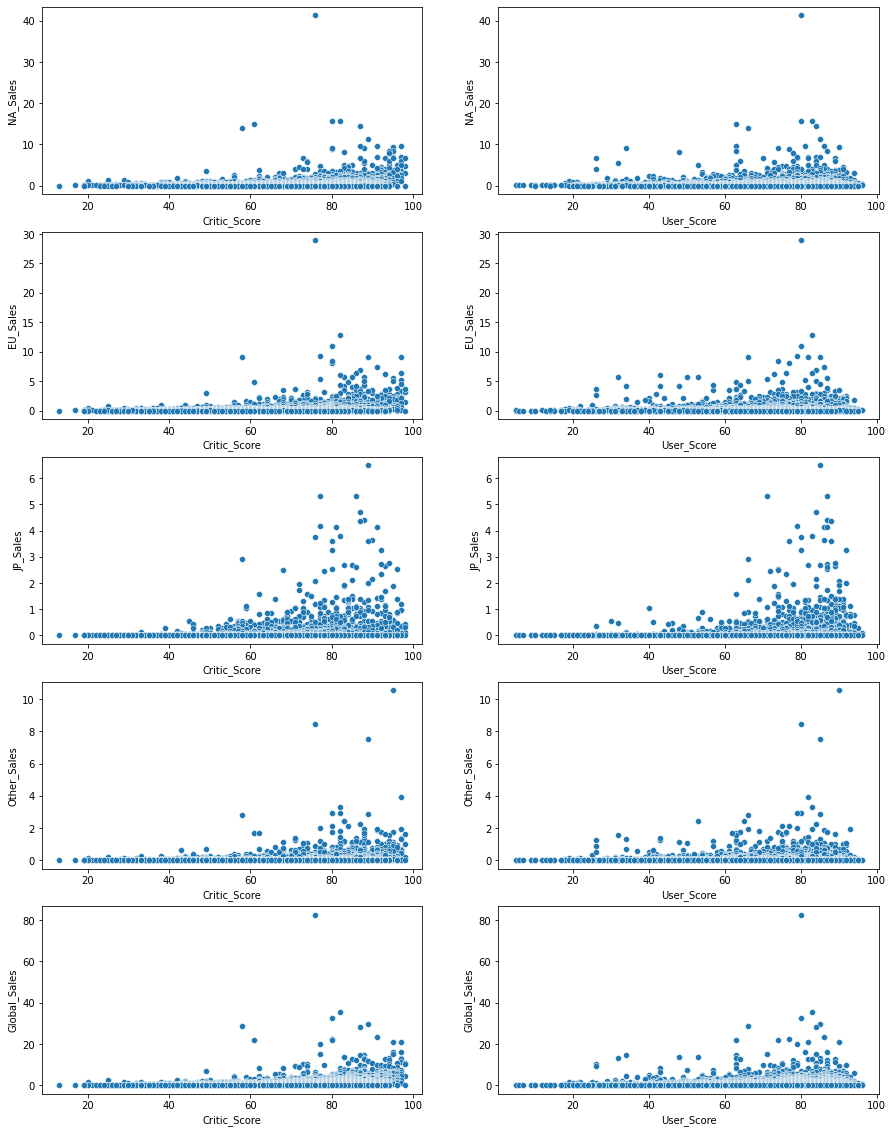

In [14]:
fig, axes = plt.subplots(nrows=len(sales), ncols=len(reviews), figsize=(15, 20))
for i, sales in enumerate(sales):
    for k, score in enumerate(reviews):
        sns.scatterplot(score, sales, data=rs, ax=axes[i, k])
plt.show()

Распределение сильно прижато к оси абсцисс, однако, как можно заметить из представленных графиков, наблюдается вполне логичная закономерность: чем выше оценка игры (особенно пользовательская), тем выше уровень продаж данной игры. Чтобы убедиться в правильности предложенной гипотезы, подробнее взглянем на то, как правило работает для игр, чьи продажи ниже 3 млн на глобальном рынке.

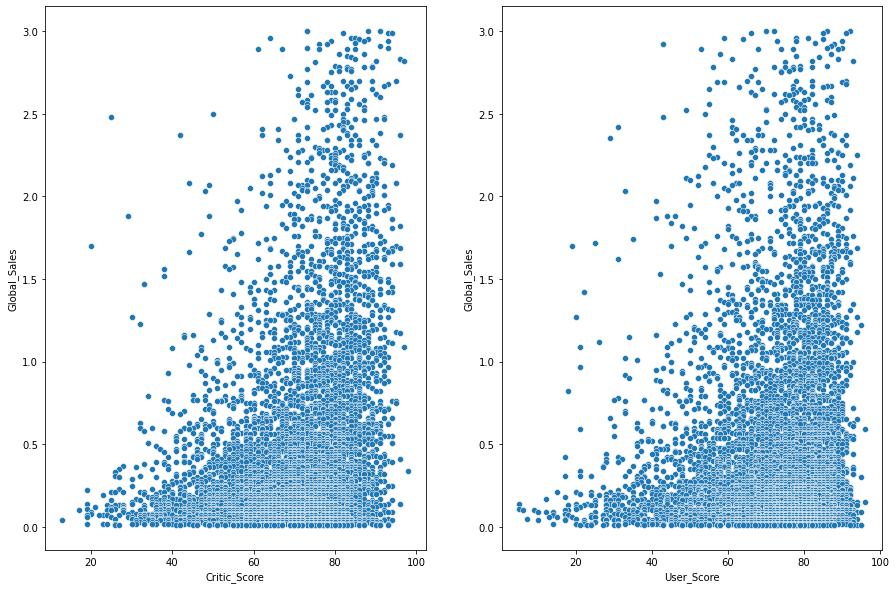

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=len(reviews), figsize=(15, 10))
for k, score in enumerate(reviews):
    sns.scatterplot(score, sales, data=rs[rs['Global_Sales'] <= 3.0], ax=axes[k])
plt.show()

Указанная закономерность действительно существует, однако правильнее будет утверждать следующее предположение: чем выше оценка на игру, тем больше вероятность, что игра станет бестселлером.

In [16]:
rs.corr()

,Critic_Score,User_Score,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
Critic_Score,1.000000,0.580878,0.233367,0.212023,0.146175,0.191105,0.236953
User_Score,0.580878,1.000000,0.086496,0.055573,0.127103,0.057359,0.088583
NA_Sales,0.233367,0.086496,1.000000,0.839998,0.467134,0.727141,0.955487
EU_Sales,0.212023,0.055573,0.839998,1.000000,0.518734,0.716482,0.938667
JP_Sales,0.146175,0.127103,0.467134,0.518734,1.000000,0.394249,0.612539
Other_Sales,0.191105,0.057359,0.727141,0.716482,0.394249,1.000000,0.804513
Global_Sales,0.236953,0.088583,0.955487,0.938667,0.612539,0.804513,1.000000


Коэффициент корреляции для Critic_Score и Global_Sales равен примерно 0.24, для User_Score и Global_Sales примерно 0.09, что, конечно же, слишком мало, чтобы говорить о существенной корреляции между оценками и продажами. В самом деле, тот факт, что игра отличная, не гарантирует высоких продаж, и наоборот – огромные продажи могут быть у игры с низкой оценкой. Данный факт можно объяснить тем, что зачастую аудитории разных жанров существенно отличаются друг от друга.

### 4. Indicate the most profitable and lowest sales genres for NA, EU, JP.

Рассмотрим теперь жанры наиболее и наименее продаваемых игр по регионам.

In [17]:
# исходная выборка содержит две игры без жанра, удалим их из полученной выборки
rg = df[['Genre', 'NA_Sales', 'EU_Sales', 'JP_Sales']].dropna()
rg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16717 entries, 0 to 16718
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Genre     16717 non-null  object 
 1   NA_Sales  16717 non-null  float64
 2   EU_Sales  16717 non-null  float64
 3   JP_Sales  16717 non-null  float64
dtypes: float64(3), object(1)
memory usage: 653.0+ KB


In [18]:
# получим список жанров
genres = sorted(set(rg['Genre']))

genres_info = []
for genre in genres:
    # выделяем жанр
    genres_data = rg[rg['Genre'] == genre]
    
    # смотрим на выборочное среднее и медиану жанра
    median_sales = genres_data.median()
    mean_sales = genres_data.mean()

    # записываем инфу
    genres_info.append((genre, *zip(median_sales, mean_sales)))
    
# выводим инфу
for k, reg in enumerate(['North America', 'Europe', 'Japan']):
    reg_info_med = sorted(genres_info, key=lambda x: x[k + 1][0])
    reg_info_mean = sorted(genres_info, key=lambda x: x[k + 1][1])
    
    if reg_info_mean[0][0] == reg_info_med[0][0]:
        print('Наименее популярный в {} жанр – {}'.format(reg, reg_info_med[0][0]))
    else:
        print('Наименее популярный в {} жанр в плане медианного значения – {}, в плане среднего – {}'.format(
            reg, reg_info_med[0][0], reg_info_mean[0][0]))
    
    if reg_info_mean[-1][0] == reg_info_med[-1][0]:
        print('Наиболее продаваемый в {} жанр – {}'.format(reg, reg_info_med[-1][0]))
    else:
        print('Наиболее продаваемый в {} жанр в плане медианного значения – {}, в плане среднего – {}'.format(
            reg, reg_info_med[-1][0], reg_info_mean[-1][0]))
        
    print()

Наименее популярный в North America жанр – Adventure
Наиболее продаваемый в North America жанр – Platform

Наименее популярный в Europe жанр – Adventure
Наиболее продаваемый в Europe жанр – Shooter

Наименее популярный в Japan жанр в плане медианного значения – Action, в плане среднего – Shooter
Наиболее продаваемый в Japan жанр – Role-Playing



### 5. Global sales forecast. 

Проанализируем, какие признаки мы можем использовать для обучения модели и построения предсказаний.
- **Platform** — **используем.**
- **YearofRelease** — *попробуем.*
- **Genre** — **используем.**
- **Publisher** — **используем.**
- **NA_Sales** — не используем, т.к. значение целевой метки Global_Sales включает в себя данные значения.
- **EU_Sales** — аналогично не используем.
- **JP_Sales** — аналогично не используем.
- **Other_Sales** — аналогично не используем.
- **Global_Sales** — целевая метка.
- **Critic_Score** — **используем** (в предположении, что в момент выхода игры нам известы отзывы критиков, которые уже поиграли в игру).
- **Criticcount** — *попробуем.*
- **User_Score** — **используем** (в том же предположении, что и для Critic_Score).
- **Usercount** — *попробуем.*
- **Developer** — **используем.**
- **Rating** — **используем.**

Вновь обратимся к тому, сколько пропущенных значений присутствует в выборке.

In [19]:
features_na = dict(df.isna().sum())
for feature, num_na in features_na.items():
    print('{: <18}  {}  {: >6}'.format(feature, '·', str(num_na)))

Name                ·       2
Platform            ·       0
Year_of_Release     ·     269
Genre               ·       2
Publisher           ·      54
NA_Sales            ·       0
EU_Sales            ·       0
JP_Sales            ·       0
Other_Sales         ·       0
Global_Sales        ·       0
Critic_Score        ·    8582
Critic_Count        ·    8582
User_Score          ·    6704
User_Count          ·    9129
Developer           ·    6623
Rating              ·    6769


Заметим, что последние 6 признаков имеют половину пропусков, также есть немного пропусков в году и издательстве. Вполне логично предположить, что если мы будем предсказывать продажи только по признакам Platform, Genre и Publisher, то ошибка будет достаточно большой. Однако и заполнить как-либо пропуски тоже будет не совсем корректно, ведь иначе это будет влиять на половину наших предсказаний. Попробуем удалить все пустые значения из выборки и посмотрим, сколько записей в ней останется.

In [20]:
# удаляем указанные ранее tbd
for_test_ = df.drop(df.index[df['User_Score'] == 'tbd'], inplace=False)
for_test_.shape

(14294, 16)

In [21]:
# удаляем все записи, в которых есть пропущенные значения признаков
for_test_ = for_test_.dropna(inplace=False)
# преобразуем столбцы оценок к целочисленному типу
for_test_.loc[:, 'User_Score'] = (for_test_.loc[:, 'User_Score'].astype(float) * 10).astype(int)
for_test_.loc[:, 'Critic_Score'] = for_test_['Critic_Score'].astype(int)
for_test_.shape

(6825, 16)

Объем выборки уменьшился почти на 10 тысяч записей, тем не менее такого объема данных должно быть достаточно для обучения модели. Кроме того, в задании не указано, какие именно глобальные продажи необходимо будет предсказывать. Вполне логично предположить, что цель – будущие продажи для новых игр. В таком случае, будем рассматривать только те игры, которые вышли после 2000 года. 2000 год выбран потому, что к этому времени индустрия видеоигр уже более менее сформировалась в том ключе, в каком мы знаем её сейчас.

In [22]:
for_test_ = for_test_[for_test_['Year_of_Release'] > 2000]
for_test_.shape

(6644, 16)

Как мы видим, объем выборки по сравнению с прошлым шагом изменился несущественно. Примем полученную выборку в качестве той, с которой будем работать в дальнейшем.

In [23]:
data = for_test_.copy()

Выберем два набора признаков, которые включим в обучающую выборку: первый состоит только из тех, что выше имеют пометку "используем", второй — пометки "используем" и "попробуем". Кроме того, отсортируем данные по году выпуска игр в обоих наборах.

In [24]:
features = ['Platform', 'Genre', 'Publisher', 'Critic_Score', 'User_Score', 'Developer', 'Rating', 'Global_Sales']
features_full = ['Platform', 'Year_of_Release', 'Genre', 'Publisher', 'Critic_Score', 'Critic_Count', 
                 'User_Score', 'User_Count', 'Developer', 'Rating', 'Global_Sales']

In [25]:
# минимальный набор
raw_data = data.sort_values(by='Year_of_Release')[features]
raw_data.head()

,Platform,Genre,Publisher,Critic_Score,User_Score,Developer,Rating,Global_Sales
5192,PS2,Role-Playing,Sony Computer Entertainment,70,85,Zener Works,T,0.36
8033,PS,Action,Eidos Interactive,84,89,Kronos Digital Entertainment,M,0.18
4147,PS2,Action,Sony Computer Entertainment,90,88,SCE Japan Studio,T,0.47
2588,PS,Racing,Take-Two Interactive,34,53,Deibus Studios,E,0.79
4553,GBA,Role-Playing,Capcom,79,89,Capcom,E,0.42


In [26]:
# полный набор
raw_data_full = data.sort_values(by='Year_of_Release')[features_full]
raw_data_full.loc[:, ['Year_of_Release' ,'Critic_Count', 'User_Count']] = raw_data_full[
    ['Year_of_Release', 'Critic_Count', 'User_Count']].astype(int)
raw_data_full.head()

,Platform,Year_of_Release,Genre,Publisher,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,Global_Sales
5192,PS2,2001,Role-Playing,Sony Computer Entertainment,70,23,85,14,Zener Works,T,0.36
8033,PS,2001,Action,Eidos Interactive,84,15,89,17,Kronos Digital Entertainment,M,0.18
4147,PS2,2001,Action,Sony Computer Entertainment,90,59,88,328,SCE Japan Studio,T,0.47
2588,PS,2001,Racing,Take-Two Interactive,34,6,53,6,Deibus Studios,E,0.79
4553,GBA,2001,Role-Playing,Capcom,79,10,89,24,Capcom,E,0.42


#### Линейная регрессия.

Поработаем для начала с первым набором. Выделим тестовую выборку - последние 500 наиболее актуальных игр, выделим обучающую выборку.

In [27]:
train_data = np.array(raw_data.iloc[:-500, :-1])
train_labels = np.array(raw_data.iloc[:-500, -1])

test_data = np.array(raw_data.iloc[-500:, :-1])
test_labels = np.array(raw_data.iloc[-500:, -1])

Выпишем индексы числовых и категориальных признаков для дальнейшего определения pipeline'а.

In [28]:
numeric_data_indices = np.array([3, 4])
categorical_data_indices = np.array([0, 1, 2, 5, 6])

В качестве регрессора будем использовать линейную модель, обучаемую стохастическим градиентным спуском.

In [29]:
regressor_1 = SGDRegressor(random_state=0)

Определим pipeline для более удобной работы с данными.

In [30]:
estimator_1 = pipeline.Pipeline(steps=[       
    ('feature_processing', 
     pipeline.FeatureUnion(transformer_list=[        
            
            # обрабатываем числовые признаки (нормализуем)
            ('numeric_variables_processing', pipeline.Pipeline(steps=[
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, numeric_data_indices])),
                ('scaling', preprocessing.StandardScaler(with_mean=True, with_std=True))            
                        ])),
        
            # обрабатываем категориальные признаки (преобразуем один категориальный признак в множество бинарных)
            ('categorical_variables_processing', pipeline.Pipeline(steps=[
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, categorical_data_indices])),
                ('hot_encoding', preprocessing.OneHotEncoder(handle_unknown='ignore'))            
                        ])),
        ])),
    ('model_fitting', regressor_1)
    ]
)

Обучим модель.

In [31]:
estimator_1.fit(train_data, train_labels)

Pipeline(steps=[('feature_processing',
                 FeatureUnion(transformer_list=[('numeric_variables_processing',
                                                 Pipeline(steps=[('selecting',
                                                                  FunctionTransformer(func=<function <lambda> at 0x00000224F6F2E550>)),
                                                                 ('scaling',
                                                                  StandardScaler())])),
                                                ('categorical_variables_processing',
                                                 Pipeline(steps=[('selecting',
                                                                  FunctionTransformer(func=<function <lambda> at 0x00000224F6F2E0D0>)),
                                                                 ('hot_encoding',
                                                                  OneHotEncoder(handle_unknown='ignore'))]))])),
     

Проверим качество модель на отложенной выборке.

In [32]:
metrics.mean_absolute_error(test_labels, estimator_1.predict(test_data))

0.7582592669633111

Заметим, что данное значение – это среднеквадратичная ошибка глобальных продаж, исчисляемая в миллионах. В таком ключе, данное значение слишком велико, чтобы считать качество регрессии удовлетворительным.

Попробуем улучшить линейный классификатор с помощью перебора параметров модели по сетке на кросс-валидации.

In [33]:
parameters_grid_1 = {
    'model_fitting__alpha': [0.0001, 0.001, 0,1],
    'model_fitting__eta0': [0.001, 0.05],
    'model_fitting__loss' : ['huber', 'epsilon_insensitive', 'squared_loss'],
    'model_fitting__max_iter': [3, 5, 10, 20], 
    'model_fitting__penalty' : ['l1', 'l2']
}

In [34]:
grid_cv_1 = model_selection.GridSearchCV(estimator_1, parameters_grid_1, scoring='neg_mean_absolute_error', cv=4)

In [35]:
%%time
grid_cv_1.fit(train_data, train_labels)

Wall time: 18.9 s


GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('feature_processing',
                                        FeatureUnion(transformer_list=[('numeric_variables_processing',
                                                                        Pipeline(steps=[('selecting',
                                                                                         FunctionTransformer(func=<function <lambda> at 0x00000224F6F2E550>)),
                                                                                        ('scaling',
                                                                                         StandardScaler())])),
                                                                       ('categorical_variables_processing',
                                                                        Pipeline(steps=[('selecting',
                                                                                         FunctionTransformer(func=<fun...
           

Посмотрим на среднеквадратичную ошибку прогноза после перебора параметров на сетке.

In [36]:
test_predictions = grid_cv_1.best_estimator_.predict(test_data)
metrics.mean_absolute_error(test_labels, test_predictions)

0.5504249409077312

Также посмотрим на пары целевые данные / предсказание.

In [37]:
print(*zip(test_labels[:10], test_predictions[:10]), sep='\n')

(0.43, 0.46653953057927244)
(0.16, 0.5135529757639297)
(3.37, 0.8180490155694025)
(0.28, 0.4293788660507361)
(0.15, 0.6492293298464057)
(0.06, 0.3752255059167851)
(0.05, 0.06098014176000345)
(1.23, 0.9605974670490662)
(0.05, 0.4250119785538312)
(0.06, 0.17477646843180983)


Такие предсказания, с очевидностью, в большинстве случаев не удовлетворительны. Проиллюстрируем, насколько регрессор справился со своей задачей с помощью следующего графика.

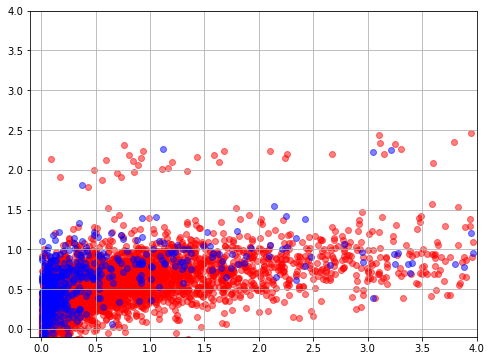

In [38]:
plt.figure(figsize=(8, 6))
plt.grid(True)
plt.xlim(-0.1, 4)
plt.ylim(-0.1, 4)
plt.scatter(train_labels, grid_cv_1.best_estimator_.predict(train_data), alpha=0.5, color = 'red')
plt.scatter(test_labels, grid_cv_1.best_estimator_.predict(test_data), alpha=0.5, color = 'blue')
plt.show()

Здесь по оси абцисс отложены истинные значения, а по оси ординат — предсказанные, красным цветом обозначены точки из обучающей выборки, синим — из тестовой. В случае, если бы регрессор был идеальным, все точки лежали бы на диагонали. У нас, как можно заметить, не так. 

#### Попробуем применить другую модель — случайный лес.

In [39]:
regressor_2 = RandomForestRegressor(random_state=0)

In [40]:
estimator_2 = pipeline.Pipeline(steps=[       
    ('feature_processing', pipeline.FeatureUnion(transformer_list=[        
                    
            #numeric
            ('numeric_variables_processing', pipeline.Pipeline(steps=[
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, numeric_data_indices])),
                ('scaling', preprocessing.StandardScaler(with_mean=True, with_std=True))            
                        ])),
        
            #categorical
            ('categorical_variables_processing', pipeline.Pipeline(steps=[
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, categorical_data_indices])),
                ('hot_encoding', preprocessing.OneHotEncoder(handle_unknown='ignore'))            
                        ])),
        ])),
    ('model_fitting', regressor_2)
    ]
)

Сразу переберем параметры на сетке.

In [41]:
parameters_grid_2 = {
    'model_fitting__max_depth': [15, 25, 40, 50],
    'model_fitting__n_estimators': [40, 60, 80]
}

In [42]:
grid_cv_2 = model_selection.GridSearchCV(estimator_2, parameters_grid_2, scoring='neg_mean_absolute_error', cv=4)

In [43]:
%%time
grid_cv_2.fit(train_data, train_labels)

Wall time: 4min 54s


GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('feature_processing',
                                        FeatureUnion(transformer_list=[('numeric_variables_processing',
                                                                        Pipeline(steps=[('selecting',
                                                                                         FunctionTransformer(func=<function <lambda> at 0x00000224F70C8280>)),
                                                                                        ('scaling',
                                                                                         StandardScaler())])),
                                                                       ('categorical_variables_processing',
                                                                        Pipeline(steps=[('selecting',
                                                                                         FunctionTransformer(func=<function <lambda> 

In [44]:
print(-grid_cv_2.best_score_)
print(grid_cv_2.best_params_)

0.5589356635050082
{'model_fitting__max_depth': 50, 'model_fitting__n_estimators': 80}


Посмотрим на среднеквадратичную ошибку прогноза после перебора параметров на сетке.

In [45]:
test_predictions = grid_cv_2.best_estimator_.predict(test_data)
metrics.mean_absolute_error(test_labels, test_predictions)

0.6117302860040932

Также посмотрим на пары целевые данные / предсказание.

In [46]:
print(*zip(test_labels[:10], test_predictions[:10]), sep='\n')

(0.43, 0.601647277992688)
(0.16, 0.26571709021478507)
(3.37, 0.7782282884709083)
(0.28, 0.3951304957044383)
(0.15, 0.36022967239554027)
(0.06, 0.22022433066282104)
(0.05, 0.024804357457413877)
(1.23, 0.48429367765275133)
(0.05, 0.35534482955896496)
(0.06, 0.2262073105551338)


Ошибка всё такая же большая, однако предсказания выглядят "лучше". Вновь проиллюстрируем, насколько регрессор справился со своей задачей с помощью следующего графика.

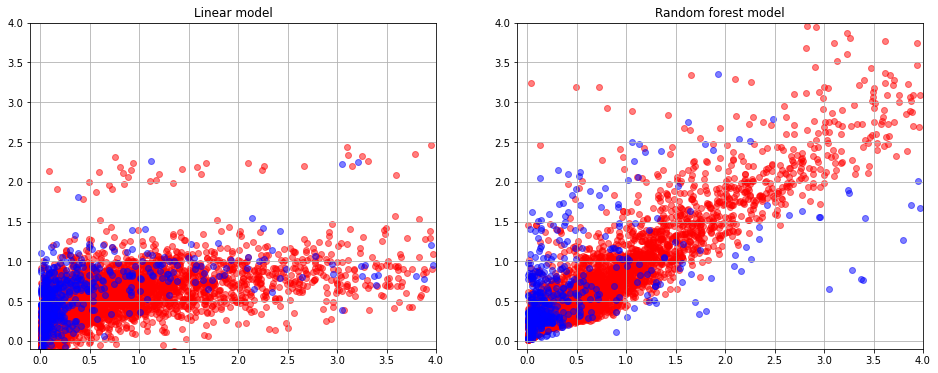

In [47]:
plt.figure(figsize=(16, 6))

plt.subplot(1,2,1)
plt.grid(True)
plt.xlim(-0.1, 8)
plt.ylim(-0.1, 8)
plt.scatter(train_labels, grid_cv_1.best_estimator_.predict(train_data), alpha=0.5, color = 'red')
plt.scatter(test_labels, grid_cv_1.best_estimator_.predict(test_data), alpha=0.5, color = 'blue')
plt.title('Linear model')

plt.subplot(1,2,2)
plt.grid(True)
plt.xlim(-0.1, 8)
plt.ylim(-0.1, 8)
plt.scatter(train_labels, grid_cv_2.best_estimator_.predict(train_data), alpha=0.5, color = 'red')
plt.scatter(test_labels, grid_cv_2.best_estimator_.predict(test_data), alpha=0.5, color = 'blue')
plt.title('Random forest model')

plt.show()

Заметим, что в данном случае регрессор действительно справился лучше, т.к несмотря на большой разброс, точки лежат гораздо ближе к диагонали.

#### Вновь линейная модель.

Ранее мы рассматривали два набора признаков и решили задачу для первого из них. Повторим для второго из них.

In [48]:
train_data_full = np.array(raw_data_full.iloc[:-500, :-1])
test_data_full = np.array(raw_data_full.iloc[-500:, :-1])

Выпишем индексы числовых и категориальных признаков для дальнейшего определения pipeline'а.

In [49]:
numeric_data_indices_full = np.array([4, 5, 6, 7])
categorical_data_indices_full = np.array([0, 1, 2, 3, 8, 9])

В качестве регрессора будем вновь использовать линейную модель, обучаемую стохастическим градиентным спуском.

In [50]:
regressor_3 = SGDRegressor(random_state=0)

In [51]:
estimator_3 = pipeline.Pipeline(steps=[       
    ('feature_processing', 
     pipeline.FeatureUnion(transformer_list=[        
            
            # обрабатываем числовые признаки (нормализуем)
            ('numeric_variables_processing', pipeline.Pipeline(steps=[
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, numeric_data_indices_full])),
                ('scaling', preprocessing.StandardScaler(with_mean=True, with_std=True))            
                        ])),
        
            # обрабатываем категориальные признаки (преобразуем один категориальный признак в множество бинарных)
            ('categorical_variables_processing', pipeline.Pipeline(steps=[
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, categorical_data_indices_full])),
                ('hot_encoding', preprocessing.OneHotEncoder(handle_unknown='ignore'))            
                        ])),
        ])),
    ('model_fitting', regressor_3)
    ]
)

Попробуем найти оптимальный линейный классификатор с помощью перебора параметров модели по сетке на кросс-валидации.

In [52]:
parameters_grid_3 = {
    'model_fitting__alpha': [0.0001, 0.001, 0,1],
    'model_fitting__eta0': [0.001, 0.05],
    'model_fitting__loss' : ['huber', 'epsilon_insensitive', 'squared_loss'],
    'model_fitting__max_iter': [3, 5, 10, 20], 
    'model_fitting__penalty' : ['l1', 'l2']
}

In [53]:
grid_cv_3 = model_selection.GridSearchCV(estimator_3, parameters_grid_3, scoring='neg_mean_absolute_error', cv=4)

In [54]:
%%time
grid_cv_3.fit(train_data_full, train_labels)

Wall time: 22.3 s


GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('feature_processing',
                                        FeatureUnion(transformer_list=[('numeric_variables_processing',
                                                                        Pipeline(steps=[('selecting',
                                                                                         FunctionTransformer(func=<function <lambda> at 0x00000224F7181A60>)),
                                                                                        ('scaling',
                                                                                         StandardScaler())])),
                                                                       ('categorical_variables_processing',
                                                                        Pipeline(steps=[('selecting',
                                                                                         FunctionTransformer(func=<fun...
           

Посмотрим на среднеквадратичную ошибку прогноза после перебора параметров на сетке.

In [55]:
test_predictions = grid_cv_3.best_estimator_.predict(test_data_full)
metrics.mean_absolute_error(test_labels, test_predictions)

0.4594683105454818

Также посмотрим на пары целевые данные / предсказание.

In [56]:
print(*zip(test_labels[:10], test_predictions[:10]), sep='\n')

(0.43, 0.54219526708362)
(0.16, 0.3052781910190163)
(3.37, 1.4928196311083561)
(0.28, 0.3954484691718888)
(0.15, 0.7518053946213166)
(0.06, 0.16025675675770448)
(0.05, -0.08404830572673619)
(1.23, 1.4457590537897809)
(0.05, 0.25662215683752554)
(0.06, 0.010965862124940662)


Предсказания получаем лучше тех, что были ранее при использовании линейной модели. Проиллюстрируем, насколько регрессор справился со своей задачей с помощью следующего графика.

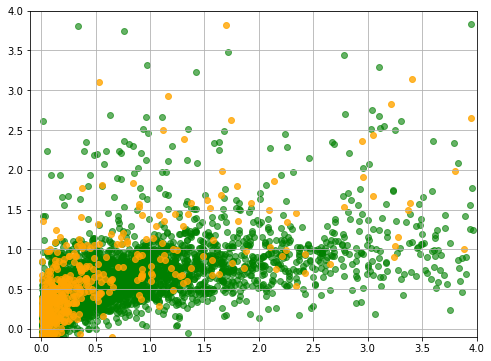

In [57]:
plt.figure(figsize=(8, 6))
plt.grid(True)
plt.xlim(-0.1, 4)
plt.ylim(-0.1, 4)
plt.scatter(train_labels, grid_cv_3.best_estimator_.predict(train_data_full), alpha=0.6, color = 'green')
plt.scatter(test_labels, grid_cv_3.best_estimator_.predict(test_data_full), alpha=0.8, color = 'orange')
plt.show()

Значения лежат лишь немногим ближе к диагонали, слишком разбросаны.

#### Вновь случайный лес.

In [58]:
regressor_4 = RandomForestRegressor(random_state=0)

In [59]:
estimator_4 = pipeline.Pipeline(steps=[       
    ('feature_processing', pipeline.FeatureUnion(transformer_list=[        
                    
            #numeric
            ('numeric_variables_processing', pipeline.Pipeline(steps=[
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, numeric_data_indices_full])),
                ('scaling', preprocessing.StandardScaler(with_mean=True, with_std=True))            
                        ])),
        
            #categorical
            ('categorical_variables_processing', pipeline.Pipeline(steps=[
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, categorical_data_indices_full])),
                ('hot_encoding', preprocessing.OneHotEncoder(handle_unknown='ignore'))            
                        ])),
        ])),
    ('model_fitting', regressor_4)
    ]
)

Сразу переберем параметры на сетке.

In [60]:
parameters_grid_4 = {
    'model_fitting__max_depth': [30, 40, 50],
    'model_fitting__n_estimators': [60, 80]
}

In [61]:
grid_cv_4 = model_selection.GridSearchCV(estimator_4, parameters_grid_4, scoring='neg_mean_absolute_error', cv=4)

In [62]:
%%time
grid_cv_4.fit(train_data_full, train_labels)

Wall time: 6min 26s


GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('feature_processing',
                                        FeatureUnion(transformer_list=[('numeric_variables_processing',
                                                                        Pipeline(steps=[('selecting',
                                                                                         FunctionTransformer(func=<function <lambda> at 0x00000224F72811F0>)),
                                                                                        ('scaling',
                                                                                         StandardScaler())])),
                                                                       ('categorical_variables_processing',
                                                                        Pipeline(steps=[('selecting',
                                                                                         FunctionTransformer(func=<function <lambda> 

In [63]:
print(-grid_cv_4.best_score_)
print(grid_cv_4.best_params_)

0.5278778670380259
{'model_fitting__max_depth': 50, 'model_fitting__n_estimators': 60}


Посмотрим на среднеквадратичную ошибку прогноза после перебора параметров на сетке.

In [64]:
test_predictions = grid_cv_4.best_estimator_.predict(test_data_full)
metrics.mean_absolute_error(test_labels, test_predictions)

0.609015777418276

Также посмотрим на пары целевые данные / предсказание.

In [65]:
print(*zip(test_labels[:10], test_predictions[:10]), sep='\n')

(0.43, 0.9611666666666667)
(0.16, 0.2019345130387248)
(3.37, 8.887000000000002)
(0.28, 0.3876369657097287)
(0.15, 1.0487760695187165)
(0.06, 0.2314509868219584)
(0.05, 0.05466666666666668)
(1.23, 2.9833333333333334)
(0.05, 0.2368333333333334)
(0.06, 0.08694966369592085)


Проиллюстрируем, насколько регрессор справился со своей задачей.

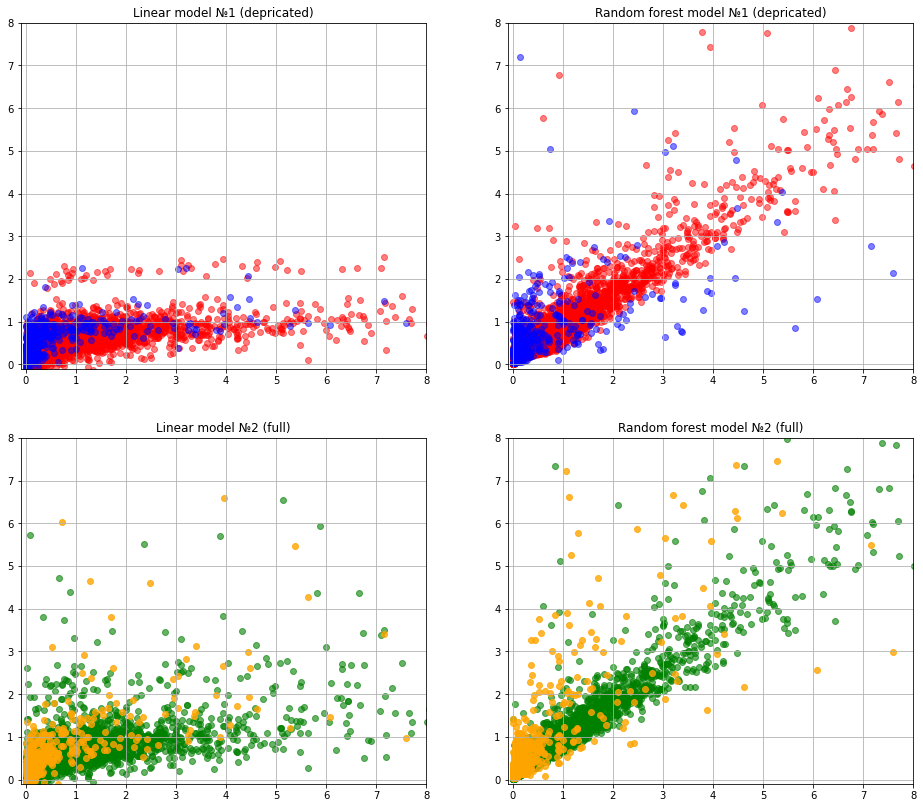

In [67]:
plt.figure(figsize=(16, 14))

plt.subplot(2, 2, 1)
plt.grid(True)
plt.xlim(-0.1, 8)
plt.ylim(-0.1, 8)
plt.scatter(train_labels, grid_cv_1.best_estimator_.predict(train_data), alpha=0.5, color = 'red')
plt.scatter(test_labels, grid_cv_1.best_estimator_.predict(test_data), alpha=0.5, color = 'blue')
plt.title('Linear model №1 (depricated)')

plt.subplot(2, 2, 2)
plt.grid(True)
plt.xlim(-0.1, 8)
plt.ylim(-0.1, 8)
plt.scatter(train_labels, grid_cv_2.best_estimator_.predict(train_data), alpha=0.5, color = 'red')
plt.scatter(test_labels, grid_cv_2.best_estimator_.predict(test_data), alpha=0.5, color = 'blue')
plt.title('Random forest model №1 (depricated)')

plt.subplot(2, 2, 3)
plt.grid(True)
plt.xlim(-0.1, 8)
plt.ylim(-0.1, 8)
plt.scatter(train_labels, grid_cv_3.best_estimator_.predict(train_data_full), alpha=0.6, color = 'green')
plt.scatter(test_labels, grid_cv_3.best_estimator_.predict(test_data_full), alpha=0.8, color = 'orange')
plt.title('Linear model №2 (full)')

plt.subplot(2, 2, 4)
plt.grid(True)
plt.xlim(-0.1, 8)
plt.ylim(-0.1, 8)
plt.scatter(train_labels, grid_cv_4.best_estimator_.predict(train_data_full), alpha=0.6, color = 'green')
plt.scatter(test_labels, grid_cv_4.best_estimator_.predict(test_data_full), alpha=0.8, color = 'orange')
plt.title('Random forest model №2 (full)')

plt.show()

Регрессор на базе случайного леса при полном наборе признаков ожидаемо справился лучше других рассмотренных ранее методов. Однако, важно заметить, что среднеквадратичная ошибка, полученная на отложенной тестовой выборке, все равно достаточно велика. Тем не менее, можно утверждать, что регрессор справляется со своей задачей удовлетворительно.

### Conclusion.

В качестве заключения, я хотел бы привести свои соображения по поводу того, как можно улучшить модель и какие нюансы можно исправить.
1. Попробовать избавиться от выбросов в исходных данных: удалить те игры, значение целевой метки которых выбивается на общем фоне продаж игр с похожими оценками и т.д.
2. Использовать все имеющиеся данные, т.е. не исключать игры, вышедшие до 2000 года и те, у которых отсутствуют значения некоторых признаков. Однако возникает проблема того, как моделировать недостающие значения.
3. Провести более детальное статистическое описание выборочных данных. 
4. Предсказывать не глобальные продажи, а продажи по отдельным регионам (т.е. переменные NA_Sales, EU_Sales, JP_Sales и Other_Sales), после чего складывать полученные значения. Вполне реализуемо, просто затратно с точки зрения времени и реализации.
5. Использовать другие методы. В данной задаче я использовал два знакомых мне метода, которые, на мой взгляд, могли бы решить данную задачу. В данный момент я подробнее изучаю градиентный бустинг и, предполагаю, данный метод мог бы справить не хуже случайного леса (и однозначно лучше линейной модели).

Спасибо за интересное задание!